In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
from SNARS import Snars
from time import sleep
import re
import pandas as pd
import json

## P8.1
Prepare a code which draw for given network plot of the relation $C(k)$ [20%]

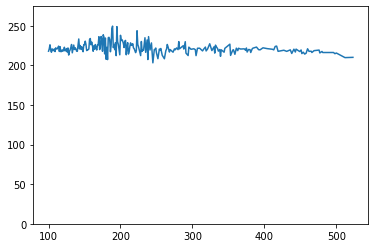

In [2]:
G = nx.generators.barabasi_albert_graph(1000, 100)
def plot_clustering_coeficient(G):
    def avg_degree(G: nx.Graph, k: int) -> float:
        dg =  dict(G.degree)
        k_nodes = [n for n, v in dg.items() if v==k] 
        averages = list(sum(dg[i] for i in G.neighbors(node))/k
                for node in k_nodes) ## list of Average degree of the nearest node for each node of degree k 
        return np.mean(averages)
    X = np.unique(list(dict(G.degree).values()))
    Y = list(map(lambda x: avg_degree(G, x), X))
    plt.plot(X, Y)
    plt.ylim(0, max(Y)*1.1)
plot_clustering_coeficient(G)

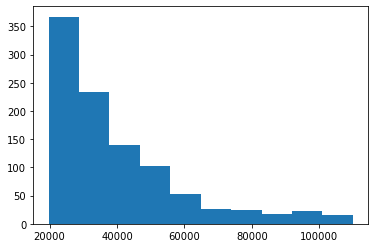

In [3]:
def plot_clustering_coeficient_hist(G):
    def avg_degree(G: nx.Graph, i: int) -> float:
        dg =  dict(G.degree)
        return sum(dg[n] for n in G.neighbors(i))## list of Average degree of the nearest node for each node of degree k 
    Y = list(map(lambda i: avg_degree(G, i), G.nodes))
    plt.hist(Y)
plot_clustering_coeficient_hist(G)

## P8.2
Find examples of hierarchical and non-hierarchical networks inavailable repositories, check by drawing graphs from the taskP8.1. [10%]

## P8.3
Load (perhaps a sub-) set of stops from the data provided byZTM Warszawa on the websitewww.ztm.waw.pl/pliki-do-pobrania/dane-rozkladowe/. Draw graphsbased on this set of vertices associated with the various typesof mass transport. [50%]

In [4]:
routes = json.load(open("routes_week.json", 'r'))
points = json.load(open("points.json", 'r'))
points = {k: (v['lon'], v['lat']) for k, v in points.items()}
edge_list=[]
for k,v in routes.items():
    for end in v.keys():
        edge_list+=[(k, end)]
G = nx.from_edgelist(edge_list)

In [5]:
# fig, ax = plt.subplots(figsize=(15,10))
# nx.draw_spring(G, node_size =1, ax=ax )

## P8.4
Calculate the basic characteristics of each layer, and the wholenetwork. [20%]

In [6]:
def mle(degree_list):
    x_min = min(degree_list)
    return 1 + len(degree_list) / (np.log(x_min) + sum(np.log(degree_list)))

def summary(G : nx.graph) -> dict:
    degrees = list(dict(G.degree).values())
    return {
        'N' : len(G.nodes),
        'E' : len(G.edges),
        '<k>': np.mean(degrees),
        'alpha': mle(degrees),
        'avg clustering': nx.average_clustering(nx.subgraph(G, max(nx.connected_components(G), key=len)))
    }
pd.DataFrame([summary(G)])

,N,E,<k>,alpha,avg clustering
0,6648,8294,2.495187,2.160073,0.01706


## P8.5

Translate GPS coordinates to configuration of the vertices anddraw graph in proper, geographic, configuration. [30%]

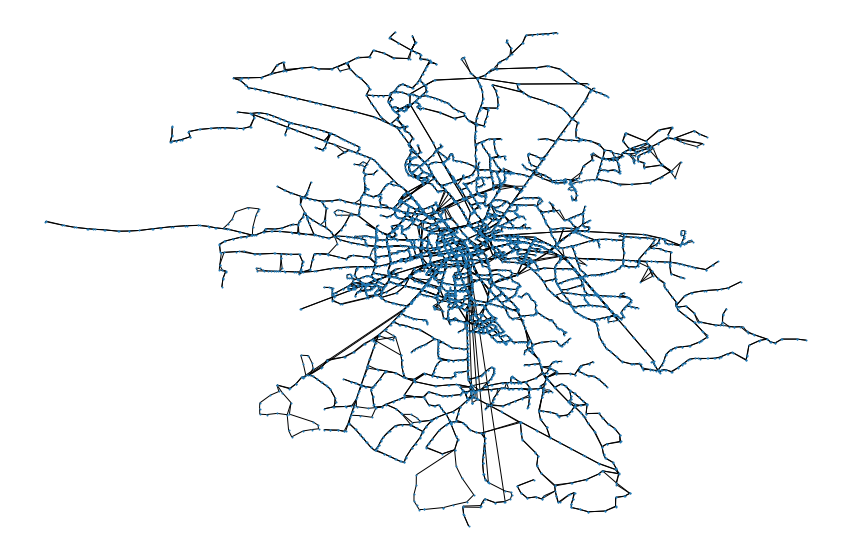

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(G, pos=points, node_size =1, ax=ax)

# P8.6
Taking into account the time table data, obtain the temporalnetwork from the graphs from the previous task. [20%]

In [8]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [ ]:
stops_by_time = {"0": {'700202'}} #tu startujemy
points_time = json.load(open("points.json", 'r'))
def get_near_points(node):
    """For each point (node) returns a set of points closer than 500meters or 2 bus stops
    """
    result=set()
    lat, lon = points_time[node]['lat'], points_time[node]['lon']
    for node, position in points_time.items():
        if haversine(lon, lat, position['lon'], position['lat'])<=0.500:
            result.add(node)  
    for node, time_needed in points_time[node]["routes"].items():
        if time_needed<=2:
            result.add(node)
    return result 
        
N=60
for i in range(1, N):          
    stops_by_time[str(i)] = stops_by_time[str(i-1)].union(set([k for node in stops_by_time[str(i-1)] for k in get_near_points(node)]))
    print(i,':', stops_by_time[str(i)])
json.dump({k: list(v) for k, v in stops_by_time.items()}, open(f'stops_by_time_{N}.json', 'w'))

1 : {'700211', '700229', '790001', '790102', '503003', '708810', '700221', '790002', '700207', '700227', '700212', '700223', '700205', 'M2T001', '700208', '503004', '700201', '700225', '700209', '708801', '790101', '700216', '700210', '701306', '791101', '700204', '700202', '700214', '700230', '503001'}
2 : {'703306', '701310', '790102', '503003', '701203', '790002', '405202', '708802', '700207', '701305', '708808', '405203', '502003', '700102', '508802', '700208', '503004', '502001', '701202', '700216', '700210', '701306', '426102', '510003', 'M2T005', '708801', '701309', '700211', '708903', '502004', '503905', '415204', '501901', '708805', 'M2K009', '503006', '701301', '510101', '503903', '701303', '701308', '790101', '508801', '503002', '791101', '700214', '703305', 'M1M012', '700229', '708810', '708803', '708804', '701304', '700212', '700101', '503005', '701307', '700223', '708806', '700205', '503101', '503904', '700209', '510002', '708701', '501902', 'M1K010', '708904', '700230', 

6 : {'515503', '790002', '501002', '507204', '500402', '508401', '503004', '490102', '702503', '707901', '700305', '502101', '709201', '500404', '705903', '520302', '709501', 'M1M013', '700214', '500406', '507203', 'M1M012', '506905', '708803', '503706', '701304', '502802', '700205', '515401', '700501', '704801', '515601', '512401', '700227', '404303', '700304', '700225', '702706', '506601', '300201', '520401', '400307', 'M2K010', '709402', '507305', '703706', '708603', '708205', '704402', '509501', '515504', '503006', '703902', '400115', '511601', '502601', '370602', '400314', '708701', '706402', '703901', '503202', '503901', '500206', '709404', '500902', '705801', '701405', '790201', '507308', '507303', '507103', '500308', '701202', '509901', '706902', '501901', '701504', '398302', '500201', '709004', '709403', '703001', '708604', '504402', '510302', '500505', '700209', '501902', '404202', 'M1K010', '504007', '708502', '790001', '412201', '504006', '701503', '502806', 'M2K013', '7041

8 : {'515702', '515503', '790002', '705102', '515901', '501002', '507204', '500402', '508401', '705002', '503004', '490102', '702503', '707901', '700305', '410801', '500704', '701602', '502101', '501203', '709201', '500404', '508701', '705903', '404405', '520302', '709501', 'M1M013', '700214', '500406', '507203', 'M1M012', '506905', '708803', '503706', '701304', '404504', '502802', '503802', '700205', '515401', '700501', '704801', '515601', '512401', '512002', '700227', '404303', '503803', '310602', '410807', '700304', '700225', '702706', '504401', '506601', '300201', '505902', '520401', '508601', '400307', 'M2K010', '709402', '507305', '703706', '116301', '515602', '708603', '708205', '704402', '509501', '515504', '509702', '502103', '504302', '413701', '503006', '703902', '400115', '400510', '709103', '511601', '502601', '370602', '505805', '400314', '590302', '708701', '706402', '703901', '707606', '503202', '503901', '500206', '504201', '709404', '500902', '705801', '701405', '7902

10 : {'515702', '515503', '790002', '705102', '515901', '501002', '507204', '705201', '500402', '508401', '100401', '705002', '503004', '490102', '702503', '707901', '700305', '410801', '500704', '701602', '502101', '501203', '709201', '411201', '500404', '508701', '705903', '404405', '520302', '515801', '709501', '305802', 'M1M013', '700214', '106606', '500406', '507203', 'M1M012', '506905', '708803', '503706', '701304', '411902', '404504', '502802', '503802', '700205', '515401', '700501', '302702', '603904', '704801', '503502', '515601', '512401', '512002', '700227', 'M1M015', '404303', '503803', '310602', '410807', '106602', '700304', '700225', '702706', '504401', '506601', '300201', '505902', '520401', '508601', '400307', '100501', 'M2K010', '709402', '507305', '703706', '116301', '503404', '515602', '300506', '603914', '708603', '708205', '704402', '509501', '515504', '400703', '707302', '509702', '502103', '504302', '100104', '413701', '503006', '703902', '300605', '590802', '503

11 : {'515702', '515503', '790002', '300708', '705102', '515901', '501002', '507204', '705201', '500402', '508401', '100401', '705002', '503004', '490102', '702503', '707901', '700305', '410801', '500704', '701602', '502101', '501203', '709201', '411201', '290101', '500404', '508701', '705903', '404405', 'M2K005', '520302', '515801', '709501', '305802', 'M1M013', '700214', '106606', '500406', '507203', 'M1M012', '622102', '200109', '506905', '708803', '503706', '701304', '505009', '411902', '404504', '502802', '503802', '700205', '515401', '700501', '302702', '603904', '704801', '503502', '515601', '507701', '512401', '604003', '512002', '700227', 'M1M015', '705501', '404303', '503803', '310602', '410807', '106602', '700304', '700225', '702706', '504401', '506601', '300201', '505902', '520401', '508601', '200201', '400307', '705503', '100501', 'M2K010', '709402', '504502', '507305', '703706', '116301', '200103', '503404', '515602', '300506', '603914', '708603', '708205', '300702', '704

12 : {'300801', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '410801', '604002', '500704', '701602', '501203', '709201', '290101', '500404', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '500406', '507203', 'M1M012', '622102', '200109', '311001', '708803', '503706', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '311403', '507701', '512002', 'M1M015', '332602', '404303', '503803', '700304', '504401', '506601', '520401', '508601', '200201', '400307', 'M2K010', '703706', '503404', '100606', '515602', '603914', '708205', '300702', '515504', '400703', '707302', '509702', '300705', '502103', '504302', '311404', '703902', '300605', '590802', '400510', '200203', '100703', '400605', '511601', '502601', '505805', '400314', '590302', '706402', '707606', '500206', '500902', '403302', '603908', '701405', '500101', 'M1M009', '600201', '505001', '507103', '411301', '323906', '311504', '300301', '500308', '123102', '509901', '515904', '100

13 : {'300801', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '410801', '604002', '500704', '701602', '501203', '709201', '290101', '500404', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '410401', '500406', '507203', 'M1M012', '325902', '622102', '200109', '311001', '708803', '503706', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '311403', '507701', '512002', '505201', 'M1M015', '332602', '404303', '503803', '700304', '504401', '506601', '520401', '508601', '200201', '400307', 'M2K010', '703706', '503404', '100606', '515602', '603914', '708205', '300702', '515504', '400703', '707302', '509702', '300705', '502103', '504302', '311404', '703902', '300605', '590802', '400510', '200203', '100703', '400605', '511601', '502601', '505805', '400314', '590302', '100803', '401002', '706402', '707606', '500206', '434801', '500902', '403302', '603908', '701405', '500101', 'M1M009', '600201', '505001', '507103', '411301', '323906', '311

14 : {'300801', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '410801', '604002', '500704', '701602', '501203', '709201', '290101', '500404', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '410401', '500406', '507203', 'M1M012', '325902', '622102', '200109', '200501', '311001', '708803', '503706', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '311403', '507701', '512002', '505201', 'M1M015', '332602', '404303', '503803', '700304', '504401', '506601', '520401', '508601', '200201', '400307', 'M2K010', '703706', '503404', '100606', '515602', '603914', '708205', '300702', '515504', '400703', '707302', '509702', '300705', '502103', '504302', '311404', '703902', '300605', '590802', '400510', '200203', '100703', '400605', '511601', '502601', '505805', '400314', '590302', '100803', '401002', '706402', '707606', '500206', '434801', '500902', '403302', '603908', '701405', '500101', 'M1M009', '600201', '505001', '507103', '411301', '323

15 : {'300801', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '410801', '604002', '500704', '701602', '501203', '709201', '290101', '500404', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '410401', '500406', '507203', 'M1M012', '325902', '622102', '200109', '200501', '311001', '103701', '708803', '503706', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '311403', '507701', '512002', '505201', 'M1M015', '332602', '404303', '503803', '700304', '504401', '506601', '520401', '508601', '200201', '400307', 'M2K010', '113701', '703706', '151701', '503404', '100606', '515602', '603914', '200606', '708205', '300702', '515504', '400703', '707302', '509702', '300705', '502103', '504302', '311404', '113902', '703902', '300605', '590802', '600601', '400510', '325101', '200203', '100703', '400605', '511601', '502601', '213304', '505805', '400314', '590302', '100803', '401002', '706402', '707606', '327904', '500206', '434801', '500902', '403

16 : {'300801', 'M1M006', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '410801', '604002', '500704', '701602', '114001', '501203', '709201', '290101', '500404', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '410401', '500406', '507203', 'M1M012', '325902', '622102', '200109', '200501', '311001', '103701', '708803', '503706', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '311403', '507701', '512002', '505201', 'M1M015', '332602', '404303', '503803', '700304', '504401', '506601', '520401', '508601', '200201', '400307', 'M2K010', '113701', '703706', '151701', '503404', '100606', '515602', '603914', '200606', '708205', '516103', '300702', '515504', '400703', '707302', '509702', '300705', '502103', '504302', '311404', '113902', '703902', '300605', '590802', '324401', '600601', '400510', '325101', '200203', '100703', '400605', '511601', '502601', '213304', '505805', '400314', '590302', '100803', '401002', '706402', '707606', '327

17 : {'300801', 'M1M006', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '410801', '604002', '500704', '701602', '114001', '605205', '501203', '709201', '290101', '500404', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '410401', '500406', '507203', 'M1M012', '325902', '622102', '200109', '200501', '311001', '103701', '708803', '503706', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '311403', '507701', '213601', '512002', '505201', 'M1M015', '332602', '404303', '503803', '700304', '504401', '506601', '520401', '508601', '200810', '200201', '400307', 'M2K010', '113701', '703706', '151701', '503404', '100606', '515602', '603914', '200606', '708205', '516103', '300702', '311902', '515504', '400703', '707302', '509702', '300705', '502103', '504302', '311404', '113902', '703902', '300605', '590802', '324401', '600601', '400510', '325101', '200203', '100703', '400605', '511601', '502601', '213304', '505805', '400314', '590302', '100

18 : {'M1M006', '515901', '705201', '500402', '700305', '410801', '114001', '709201', '290101', '500404', '600801', 'M2K005', '519202', '709501', '500406', '622102', '200109', '708803', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '507701', '115701', '213601', '505201', '332602', '503803', '504401', '508601', '200810', '113701', '420201', '151701', '503404', '603914', '516103', '300702', '311902', '400703', '707302', '509702', '300705', '311404', '113902', '703902', '590802', '600601', '400510', '325101', '200203', '100703', '511601', '502601', '213304', '400314', '590302', '100803', '401002', '327904', '500206', '434801', '403302', '613402', '603908', '212101', '701405', '213301', '500101', 'M1M009', '600201', '505001', '323906', '300301', '123102', '505507', '509901', '600516', '301203', '309701', '101103', '100308', '398302', '325501', '303801', '413702', '609104', '703001', '121301', '700209', '300204', '325401', '505302', '621502', '700204', '600806', '701

19 : {'M1M006', '300801', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '410801', '604002', '500704', '701602', '210102', '605505', '114001', '605205', '501203', '709201', '290101', '500404', '600801', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '410401', '500406', '507203', 'M1M012', '325902', '622102', '200109', '200501', '311001', '103701', '708803', '503706', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '605401', '311403', '507701', '115701', '213601', '512002', '505201', '622302', 'M1M015', '332602', '503803', '404303', '700304', '504401', '506601', '520401', '508601', '200810', '200201', '400307', 'M2K010', '312704', '113701', '420201', '703706', '151701', '503404', '100606', '515602', '301202', '603914', '200606', '708205', '516103', '300702', '311902', '400703', '515504', '707302', '509702', '300705', '502103', '504302', '311404', '113902', '703902', '300605', '590802', '324401', '600601', '400510', '325101', '309

20 : {'M1M006', '300801', '108302', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '410801', '604002', '500704', '701602', '210102', '605505', '114001', '605205', '501203', '709201', '290101', '500404', '600801', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '410401', '500406', '507203', 'M1M012', '325902', '622102', '200109', '200501', '311001', '103701', '708803', '503706', '502802', '700205', '700501', '302702', '603904', '704801', '503502', '605401', '311403', '507701', '115701', '213601', '148101', '512002', '505201', '622302', 'M1M015', '332602', '503803', '404303', '700304', '128251', '504401', '506601', '301302', '520401', '508601', '200810', '320601', '200201', '400307', 'M2K010', '312704', '113701', '420201', '703706', '151701', '503404', '100606', '515602', '301202', '603914', '148182', '200606', '708205', '516103', '300702', '311902', '400703', '515504', '707302', '509702', '300705', '502103', '504302', '311404', '113902', '703902', '300

21 : {'M1M006', '300801', '108302', '515901', '507204', '705201', '500402', '705002', '702503', '700305', '604508', '410801', '604002', '500704', '701602', '210102', '605505', '114001', '605205', '501203', '709201', '290101', '500404', '600801', '324010', 'M2K005', '519202', '400806', '709501', 'M1M013', '410401', '500406', '507203', 'M1M012', '325902', '605908', '622102', '200109', '200501', '311001', '103701', '708803', '503706', '502802', '700205', '126002', '700501', '302702', '603904', '704801', '503502', '605401', '311403', '507701', '115701', '213601', '148101', '512002', '505201', '622302', 'M1M015', '332602', '503803', '404303', '700304', '128251', '504401', '506601', '301302', '520401', '508601', '200810', '320601', '200201', '400307', 'M2K010', '312704', '113701', '420201', '703706', '151701', '503404', '100606', '515602', '301202', '603914', '148182', '200606', '708205', '516103', '300702', '311902', '400703', '515504', '707302', '509702', '300705', '502103', '504302', '311

22 : {'M1M006', '108302', '515901', '705201', '500402', '700305', '604508', '410801', '114001', '709201', '290101', '500404', '600801', 'M2K005', '519202', '709501', '500406', '605908', '622102', '200109', '708803', '502802', '700205', '126002', '700501', '302702', '603904', '704801', '503502', '507701', '312201', '115701', '213601', '201304', '505201', '622302', '332602', '503803', '312302', '504401', '508601', '200810', '113701', '420201', '151701', '503404', '603914', '516103', '300702', '311902', '231303', '400703', '707302', '509702', '300705', '311404', '113902', '703902', '590802', '214803', '304101', '201303', '600601', '400510', '325101', '201401', '200203', '100703', '511601', '502601', '213304', '400314', '590302', '100803', '401002', '290201', '327904', '500206', '303602', '434801', '403302', '613402', '201204', '603908', '212101', '701405', '213301', '500101', '602502', 'M1M009', '214701', '600201', '505001', '105802', '323906', '300301', '123102', '505507', '509901', '600

## P8.7
Make an animation of how traffic flows throughout the day.[30%]

In [ ]:
%matplotlib notebook
from copy import copy
from matplotlib.animation import FuncAnimation

stops_by_time = json.load(open(f"stops_by_time_{N}.json"))
fig, ax = plt.subplots(figsize=(10,10))   

def update(frame):
    try:
        ax.clear()
        G_plot = nx.Graph()
        G_plot.add_nodes_from(G.nodes)
        G_plot.add_edges_from( nx.subgraph(G, stops_by_time[str(int(frame))]).edges)
        nx.draw(G_plot, pos=points, node_size =0.05, ax=ax)
        ax.set_title(f"Iteration nr. {round(frame)}/{N}")
    except Exception as e:
        print(e)
    return ax

ani = FuncAnimation(fig, update, frames=np.linspace(0, N), interval=300)

## P8.8
Check how the selected network metrics depend on time. [20%]

In [11]:
pd.DataFrame([summary(nx.subgraph(G, stops))for time, stops in stops_by_time.items()])    

<ipython-input-6-f0303fa462f2>:3: RuntimeWarning: divide by zero encountered in log
  return 1 + len(degree_list) / (np.log(x_min) + sum(np.log(degree_list)))


,N,E,<k>,alpha,avg clustering
0,1,0,0.000000,1.0,0.000000
1,24,8,0.666667,1.0,0.000000
2,34,19,1.117647,1.0,0.000000
3,60,45,1.500000,1.0,0.000000
4,85,73,1.717647,1.0,0.039583
5,126,114,1.809524,1.0,0.072206
6,158,155,1.962025,1.0,0.083966
7,189,193,2.042328,1.0,0.084618
8,224,225,2.008929,1.0,0.064455
9,260,272,2.092308,1.0,0.058134
